In [8]:
import os
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

In [9]:
df = pd.read_csv('full_mp+jv_5k_stable_bg_dataset_new.csv')
print(f"количество материалов: {len(df)}")

количество материалов: 5961


In [10]:
TARGET_PROPERTY = ['k_1064', 'k_755', 'k_1500']
df = df[['id', 'structure_json', *TARGET_PROPERTY]].copy()
df.dropna(subset=[*TARGET_PROPERTY], inplace=True)

In [ ]:
DATA_DIR = 'alignn_data_small'

def structure_json_to_poscar(structure_json_str):
    try:
        structure_data = json.loads(structure_json_str.replace("'", '"')) 
        lattice = structure_data["lattice"]["matrix"]
        sites = structure_data["sites"]
        
        elements = []
        for site in sites:
            element = site["species"][0]["element"]
            if element not in elements:
                elements.append(element)
        
        element_counts = {elem: 0 for elem in elements}
        for site in sites:
            element = site["species"][0]["element"]
            element_counts[element] += 1
        
        poscar = []
        poscar.append("System")
        poscar.append("1.0")  

        for vector in lattice:
            poscar.append(f"{vector[0]:.15f} {vector[1]:.15f} {vector[2]:.15f}")
        
        poscar.append(" ".join(elements))
        poscar.append(" ".join(map(str, element_counts.values())))
        poscar.append("Direct") 
        
        for elem in elements:
            for site in sites:
                if site["species"][0]["element"] == elem:
                    abc = site["abc"]
                    poscar.append(f"{abc[0]:.15f} {abc[1]:.15f} {abc[2]:.15f}")
        
        return "\n".join(poscar)
    except Exception as e:
        print(f"Ошибка при преобразовании структуры: {e}")
        return None

print("Создание POSCAR-файлов структур...")

for index, row in df.iterrows():
    structure_id = row['id']
    structure_data = row['structure_json']
    file_path = os.path.join(DATA_DIR, f'POSCAR_{structure_id}')
    
    poscar_content = structure_json_to_poscar(structure_data)
    if poscar_content:
        with open(file_path, 'w', encoding='utf-8') as f:
            f.write(poscar_content)

        with open(os.path.join(DATA_DIR, 'id_prop.csv'), 'a', encoding='utf-8') as f:
            # f.write(f"POSCAR_{row['id']},{row['k_1064']}\n")
            f.write(f"POSCAR_{row['id']},{row['k_1064']},{row['k_755']},{row['k_1500']}\n")

Создание POSCAR-файлов структур...


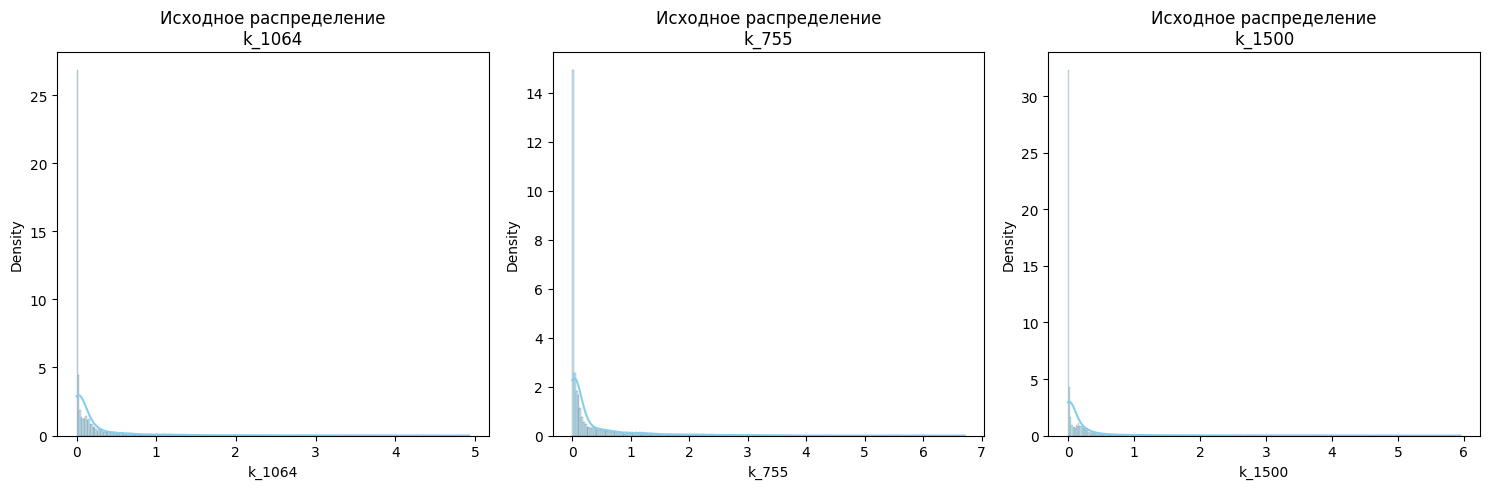

In [ ]:
# !python -m pip install seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.stats import boxcox

columns = ['k_1064', 'k_755', 'k_1500']

plt.figure(figsize=(15, 5))
for i, col in enumerate(columns, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], kde=True, stat='density', color='skyblue')
    plt.title(f'Исходное распределение\n{col}')
plt.tight_layout()
plt.show()